Mounting the Google Drive

In [0]:
#Setting up working directory if working Offline
# import os
# os.getcwd()
# os.chdir("C:/Users/harsh/Downloads/")

#Mounting gdrive if working on gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Loading Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
nltk.download('vader_lexicon')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#Reading training dataset using pandas read_excel
#trainMovieData = pd.read_excel("Training sheet.xlsx")
trainMovieData = pd.read_excel("/content/gdrive/My Drive/Datasets/Training sheet.xlsx")
trainMovieData.head()

,id,name,display_name,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,total,Category
0,7950115,Avatar,Avatar,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,"For intense epic battle sequences and warfare,...",PG-13,Wide,2784,9
1,50950115,Harry Potter and the Deathly Hallows: Part II,Harry Potter and the Deathly Hallows: Part II,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for some sequences of intense action violence ...,PG-13,Wide,1328,9
2,119870115,Transformers 3,Transformers: Dark of the Moon,2011,1,Science Fiction,Based on TV,Animation/Live Action,Action,English,for intense prolonged sequences of sci-fi acti...,PG-13,Wide,1124,9
3,119590115,Toy Story 3,Toy Story 3,2010,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,General,G,Wide,1064,9
4,91700115,Pirates of the Caribbean 4,Pirates of the Caribbean: On Stranger Tides,2011,1,Fantasy,Based on Theme Park Ride,Live Action,Adventure,English,for intense sequences of action/adventure viol...,PG-13,Wide,1044,9


In [0]:
#Reading testing dataset using pandas read_excel
#testMovieData = pd.read_excel("Scoring Sheet.xlsx")
testMovieData = pd.read_excel("/content/gdrive/My Drive/Datasets/Scoring Sheet.xlsx")
testMovieData.head()

,id,name,display_name,production_budget,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name
0,7970115,"Avengers, The (2011)",Marvel's The Avengers,225000000,2012,0,Super Hero,Based on Comic/Graphic Novel,Live Action,Adventure,English,for intense sequences of sci-fi violence and a...,PG-13,Wide
1,174540115,Dark Knight Rises The,The Dark Knight Rises,0,2012,1,Super Hero,Based on Comic/Graphic Novel,Live Action,Action,English,"for intense sequences of violence and action, ...",PG-13,Wide
2,149080115,Bond 23,Skyfall,200000000,2012,1,Contemporary Fiction,Based on Fiction Book/Short Story,Live Action,Action,English,"for intense violent sequences throughout, some...",PG-13,Wide
3,136020115,Twilight Saga Breaking Dawn Part 2 The,"The Twilight Saga: Breaking Dawn, Part 2",136200000,2012,1,Fantasy,Based on Fiction Book/Short Story,Live Action,Drama,English,for sequences of violence including disturbing...,PG-13,Wide
4,53500115,"Hobbit, The",The Hobbit: An Unexpected Journey,270000000,2012,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for extended sequences of intense fantasy acti...,PG-13,Wide


In [0]:
trainMovieData.columns

Index(['id', 'name', 'display_name', 'production_year', 'movie_sequel',
       'creative_type', 'source', 'production_method', 'genre', 'language',
       'board_rating_reason', 'movie_board_rating_display_name',
       'movie_release_pattern_display_name', 'total', 'Category'],
      dtype='object')

In [0]:
testMovieData.columns

Index(['id', 'name', 'display_name', 'production_budget', 'production_year',
       'movie_sequel', 'creative_type', 'source', 'production_method', 'genre',
       'language', 'board_rating_reason', 'movie_board_rating_display_name',
       'movie_release_pattern_display_name'],
      dtype='object')

In [0]:
#Checking no. of categories in each column in training data
trainMovieData.apply(lambda x: len(x.unique()))

id                                    1196
name                                  1196
display_name                          1195
production_year                          5
movie_sequel                             2
creative_type                            9
source                                  16
production_method                        6
genre                                   13
language                                16
board_rating_reason                   1003
movie_board_rating_display_name          6
movie_release_pattern_display_name       7
total                                  324
Category                                 9
dtype: int64

In [0]:
#Checking no. of categories in each column in testing data
testMovieData.apply(lambda x: len(x.unique()))

id                                    91
name                                  91
display_name                          91
production_budget                     26
production_year                        1
movie_sequel                           2
creative_type                          8
source                                10
production_method                      3
genre                                  9
language                               5
board_rating_reason                   79
movie_board_rating_display_name        5
movie_release_pattern_display_name     6
dtype: int64

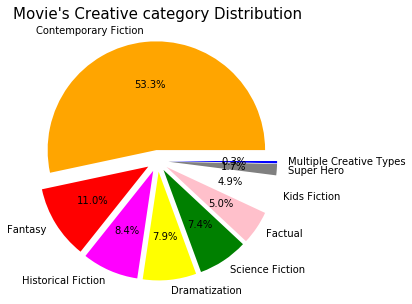

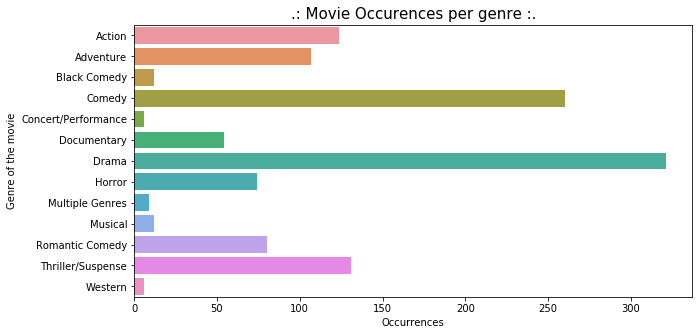

Text(0, 0.5, 'Total Gross Earnings')

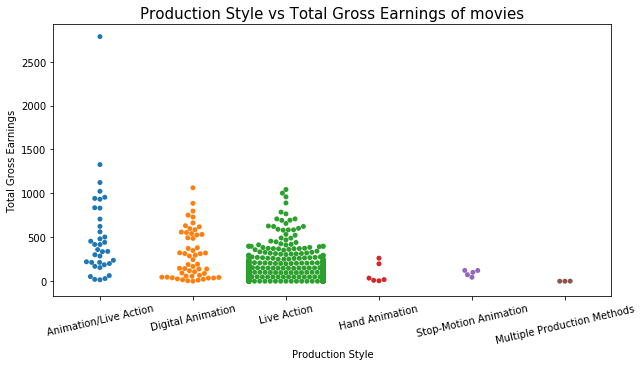

In [0]:
# Exploratory Data Analysis
# 1. Creative category of the movie distribution in dataset
labels = trainMovieData['creative_type'].value_counts().index
colors = ['orange','red','magenta','yellow','green','pink','white','grey','blue']
explode = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
sizes = trainMovieData['creative_type'].value_counts().values
plt.figure(figsize = (10,5))
plt.pie(sizes, labels=labels,explode=explode, colors=colors, autopct='%1.1f%%')
plt.title('Movie\'s Creative category Distribution',color = 'Black',fontsize = 15)
plt.show()

# 2. Genre of the movie distribution in dataset
genre_count = trainMovieData['genre'].value_counts().sort_index()
df_gCount = pd.DataFrame({'genre': genre_count.index, 'count': genre_count.values})
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x = 'count', y = 'genre', data=df_gCount)
ax.set_title('.: Movie Occurences per genre :.',color = 'Black',fontsize = 15)
ax.set_xlabel('Occurrences')
ax.set_ylabel('Genre of the movie')
plt.show()

#3 Production Style v/s Total Gross Earnings 
f, ax = plt.subplots(figsize=(10, 5))
chart3 = sns.swarmplot(x='production_method', y='total', data=trainMovieData)
chart3.set_xticklabels(chart3.get_xticklabels(), rotation=13)
ax.set_title('Production Style vs Total Gross Earnings of movies',color = 'Black',fontsize = 15)
ax.set_xlabel('Production Style')
ax.set_ylabel('Total Gross Earnings')

In [0]:
#New Dataframe for Training set fetching categorical columns to handle
trainMovieData_new = trainMovieData[['production_year','movie_sequel','creative_type','source','production_method','genre','language',
                                   'movie_board_rating_display_name','movie_release_pattern_display_name']].copy()

In [0]:
#New Dataframe for Testing set fetching categorical columns to handle
testMovieData_new = testMovieData[['production_year','movie_sequel','creative_type','source','production_method','genre','language',
                                   'movie_board_rating_display_name','movie_release_pattern_display_name']].copy()

In [0]:
train_len = len(trainMovieData_new)

#Merging both Dataframe to ensure same number of features after one hot encoding 
MergedDataset = pd.concat(objs=[trainMovieData_new, testMovieData_new], axis=0)
MergedDataset = pd.get_dummies(MergedDataset, columns=['production_year','movie_sequel','creative_type','source','production_method','genre','language',
                                   'movie_board_rating_display_name','movie_release_pattern_display_name'])
MergedDataset.head()

,production_year_2007,production_year_2008,production_year_2009,production_year_2010,production_year_2011,production_year_2012,movie_sequel_0,movie_sequel_1,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Multiple Creative Types,creative_type_Science Fiction,creative_type_Super Hero,source_Based on Comic/Graphic Novel,source_Based on Factual Book/Article,source_Based on Fiction Book/Short Story,source_Based on Folk Tale/Legend/Fairytale,source_Based on Game,source_Based on Musical or Opera,source_Based on Play,source_Based on Real Life Events,source_Based on Short Film,source_Based on TV,source_Based on Theme Park Ride,source_Based on Toy,source_Compilation,source_Original Screenplay,source_Remake,source_Spin-Off,production_method_Animation/Live Action,production_method_Digital Animation,production_method_Hand Animation,production_method_Live Action,production_method_Multiple Production Methods,production_method_Stop-Motion Animation,genre_Action,...,genre_Comedy,genre_Concert/Performance,genre_Documentary,genre_Drama,genre_Horror,genre_Multiple Genres,genre_Musical,genre_Romantic Comedy,genre_Thriller/Suspense,genre_Western,language_Arabic,language_Danish,language_English,language_Farsi,language_French,language_German,language_Hebrew,language_Hindi,language_Indonesian/Balinese,language_Italian,language_Japanese,language_Norwegian,language_Polish,language_Portuguese,language_Silent,language_Spanish,language_Swedish,movie_board_rating_display_name_G,movie_board_rating_display_name_NC-17,movie_board_rating_display_name_Not Rated,movie_board_rating_display_name_PG,movie_board_rating_display_name_PG-13,movie_board_rating_display_name_R,movie_release_pattern_display_name_Exclusive,movie_release_pattern_display_name_Expands Wide,movie_release_pattern_display_name_IMAX,movie_release_pattern_display_name_Limited,movie_release_pattern_display_name_Oscar Qualifying Run,movie_release_pattern_display_name_Special Engagement,movie_release_pattern_display_name_Wide
0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [0]:
#Splitting both Dataframe after ensuring same number of features after one hot encoding of categorical variables
trainMovieData_new = MergedDataset[:train_len].copy()
testMovieData_new = MergedDataset[train_len:].copy()

In [0]:
# Adding board_rating_reason in training dataframe
trainMovieData_new['board_rating_reason']= trainMovieData['board_rating_reason']

# Adding board_rating_reason in testing dataframe
testMovieData_new['board_rating_reason']= testMovieData['board_rating_reason']

In [0]:
#Removing spaces and converting to lowercase for board_rating_reason in Training set
trainMovieData_new['board_rating_reason'] = trainMovieData_new['board_rating_reason'].str.replace('[^\w\s]','')
for i in trainMovieData_new['board_rating_reason']:
  i= i.lower()

#Removing spaces and converting to lowercase for board_rating_reason in Testing set
testMovieData_new['board_rating_reason'] = testMovieData_new['board_rating_reason'].str.replace('[^\w\s]','')
for i in testMovieData_new['board_rating_reason']:
  i= i.lower()

#Removing stopwords and fetching unique words from board_rating_reason
sentences1 = []
uniqueWordList = trainMovieData_new.board_rating_reason.str.split(expand=True).stack()
sentences1 = [w for w in uniqueWordList if not w in stop_words]

trainMovieData_new.drop(['board_rating_reason'],axis =1)
testMovieData_new.drop(['board_rating_reason'],axis =1)

count_UniqueWordList = Counter(sentences1)
count_UniqueWordList = sorted(count_UniqueWordList, key=count_UniqueWordList.get, reverse=True)
print(count_UniqueWordList)

['language', 'violence', 'sexual', 'content', 'brief', 'drug', 'strong', 'nudity', 'thematic', 'action', 'material', 'sequences', 'images', 'sexuality', 'For', 'including', 'disturbing', 'use', 'intense', 'mild', 'humor', 'crude', 'pervasive', 'references', 'International', 'excluded', 'elements', 'throughout', 'violent', 'bloody', 'graphic', 'smoking', 'rude', 'sensuality', 'General', 'mature', 'suggestive', 'terror', 'involving', 'scene', 'scifi', 'teen', 'brutal', 'scary', 'partial', 'sexualitynudity', 'dialogue', 'drinking', 'peril', 'horror', 'grisly', 'frightening', 'reference', 'war', 'comic', 'torture', 'gore', 'fantasy', 'alcohol', 'partying', 'image', 'behavior', 'innuendo', 'situations', 'adventure', 'teens', 'rape', 'creature', 'sexrelated', 'contentnudity', 'martial', 'arts', 'abuse', 'incidental', 'battle', 'disaster', 'situation', 'accident', 'assault', 'originally', 'violencedisturbing', 'warfare', 'prolonged', 'mayhem', 'destruction', 'menace', 'comments', 'bullying', 

In [0]:
#Top 15 useful words in board_rating_reason
top_15 = []
for i in range(15):
  top_15.append(count_UniqueWordList[i])

top_15

['language',
 'violence',
 'sexual',
 'content',
 'brief',
 'drug',
 'strong',
 'nudity',
 'thematic',
 'action',
 'material',
 'sequences',
 'images',
 'sexuality',
 'For']

In [0]:
#Adding board_rating_reason's top 15 word weight column in Training data
totalcount = 0
total_c = []
for i in trainMovieData_new['board_rating_reason']:
    count = 0
    for j in top_15:
        if i.find(j) != -1:
            count += 1
        else:
            pass
    totalcount = count
    total_c.append(totalcount)

dfs = pd.DataFrame(total_c)
trainMovieData_new = trainMovieData_new.join(dfs)

#Adding board_rating_reason's top 15 word weight column in Testing data
totalcount_test = 0
total_c_test = []
for i in testMovieData_new['board_rating_reason']:
    count_test = 0
    for j in top_15:
        if i.find(j) != -1:
            count_test += 1
        else:
            pass
    totalcount_test = count
    total_c_test.append(totalcount_test)

dfs_test = pd.DataFrame(total_c_test)
testMovieData_new = testMovieData_new.join(dfs_test)

In [0]:
#Adding Label in training
trainMovieData_new['Category']= trainMovieData['Category']
label = trainMovieData_new['Category']

In [0]:
#Dropping columns to keep same number of features and relevant columns for model
trainMovieData_new = trainMovieData_new.drop(['board_rating_reason'],axis = 1)
testMovieData_new = testMovieData_new.drop(['board_rating_reason'],axis = 1)
trainMovieData_new = trainMovieData_new.drop(['Category'],axis = 1)

In [0]:
#This function prints and plots the confusion matrix.

def plot_confusion_matrix(y_true, y_pred, classes,title=None, cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig('cm_rf_1.png', dpi = 1200)
    return ax

In [0]:
#Sentiment Analysis on board_rating_reason
#Training
vader = SentimentIntensityAnalyzer()
pos, neg, compound = [], [], []
for i in trainMovieData['board_rating_reason']:
    pos.append(vader.polarity_scores(i)['pos'])
    neg.append(vader.polarity_scores(i)['neg'])
    compound.append(vader.polarity_scores(i)['compound'])

trainMovieData_new['pos'] = pos
trainMovieData_new['neg'] = neg
trainMovieData_new['compound'] = compound

#Testing
pos_test, neg_test, compound_test = [], [], []
for i in testMovieData['board_rating_reason']:
    pos_test.append(vader.polarity_scores(i)['pos'])
    neg_test.append(vader.polarity_scores(i)['neg'])
    compound_test.append(vader.polarity_scores(i)['compound'])

testMovieData_new['pos'] = pos_test
testMovieData_new['neg'] = neg_test
testMovieData_new['compound'] = compound_test

In [0]:
## Decision Tree Classifier
model_name=['Decision Tree Classifier']
models_list= [DT(max_depth = 10, min_samples_leaf = 50)]
for i, j in zip(model_name, models_list):
    scores = cross_val_score(j, trainMovieData_new , label, cv=10)
    print(i+" --> "+ "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Decision Tree Classifier --> Accuracy: 0.29 (+/- 0.09)


[7 5 5 5 8 5 8 8 8 8 3 3 5 8 7 4 5 8 4 3 5 4 2 3 5 5 4 5 4 4 2 5 2 4 4 2 2
 3 4 3 5 4 5 2 4 2 2 3 2 4 1 4 1 4 2 4 2 4 4 1 1 2 2 2 1 5 2 2 2 2 2 2 1 2
 5 1 2 2 2 1 2 2 2 1 2 1 2 2 2 2 2]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.45      0.40      0.43       168
           2       0.38      0.46      0.41       247
           3       0.33      0.32      0.33       245
           4       0.32      0.44      0.37       206
           5       0.23      0.15      0.18       132
           6       0.00      0.00      0.00        80
           7       0.20      0.18      0.19        61
           8       0.21      0.50      0.29        38
           9       0.00      0.00      0.00        19

    accuracy                           0.33      1196
   macro avg       0.24      0.27      0.24      1196
weighted avg       0.31      0.33      0.32      1196



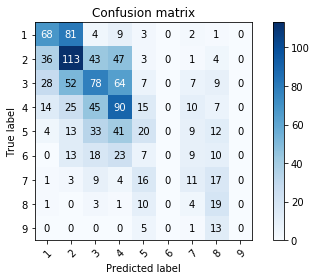

In [0]:
model = DT(max_depth = 10, min_samples_leaf = 50)
model.fit(trainMovieData_new, label)
train_predictions = model.predict(trainMovieData_new)
test_predictions = model.predict(testMovieData_new)
print(test_predictions)

plot_confusion_matrix(label, train_predictions, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9],title='Confusion matrix')
print (classification_report(label, model.predict(trainMovieData_new)))

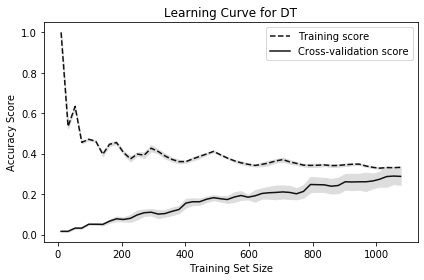

In [0]:
#DT
train_sizes, train_scores, test_scores = learning_curve(DT(max_depth = 10, min_samples_leaf = 50), 
                                                        trainMovieData_new, 
                                                        label,
                                                        cv = 10,
                                                        scoring='accuracy',
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve for DT")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [0]:
#Reporting scores:
Pred_dataframe = testMovieData[['id', 'name']].copy()
Pred_dataframe = Pred_dataframe.assign(Decision_Tree_Pred = test_predictions) 

with pd.ExcelWriter('/content/gdrive/My Drive/Datasets/Scoring sheet_HV.xlsx') as writer:  
    Pred_dataframe.to_excel(writer, sheet_name='Prediction using NB and RF')